# Introduction

The linear regression model can be used to predict an outcome $Y$ using features $X_{1}, \ldots, X_{n}$ using 
$$\hat{Y} = \hat{\beta}_{0} + \hat{\beta}_{1}X_{1} + \ldots + \hat{\beta}_{k}X_{k}.$$ Adding in regressors that are irrelevant for predicting $Y$ (given the features already included in the model) will not improve the model fit but can rather do harm. The goal of linear model selection is to pick the simplest model (least amount of features) that maximizes the model fit. This notebook considers different model selection methods including best subset selection, stepwise regression, and shrinkage methods.

# Data Processing and Description

We will explore model selection using publicly available school level achievement data from New York. The data contains test score data for several schools along with a host of school level characteristics such as race decomposition of students, percent of students that are english language learnings, school income, and attendance. Let us further take a look at the data set below. 

In [52]:
# Import dependencies
# numpy for matrix algbera
import numpy as np
# Pandas for data manipulation
import pandas as pd
# matplotlib for data visualization
from matplotlib.pyplot import *

In [53]:
# Load the school data
school_data = pd.read_csv("NYUSchoolData.csv")

# Show structure of data set
school_data.head()

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),...,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Grade 8 Math 4s - American Indian or Alaska Native,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged
0,NaN,NaN,NaN,P.S. 015 ROBERTO CLEMENTE,3.101000e+11,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,P.S. 019 ASHER LEVY,3.101000e+11,01M019,1,40.729892,-73.984231,"185 1ST AVE NEW YORK, NY 10003",...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,P.S. 020 ANNA SILVER,3.101000e+11,01M020,1,40.721274,-73.986315,"166 ESSEX ST NEW YORK, NY 10002",...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,P.S. 034 FRANKLIN D. ROOSEVELT,3.101000e+11,01M034,1,40.726147,-73.975043,"730 E 12TH ST NEW YORK, NY 10009",...,48,1,0,0,0,0,0,0,0,0
4,NaN,NaN,NaN,THE STAR ACADEMY - P.S.63,3.101000e+11,01M063,1,40.724404,-73.986360,"121 E 3RD ST NEW YORK, NY 10009",...,0,0,0,0,0,0,0,0,0,0


The data set needs some processing as most of the data is in strings which needs to be converted into numerical variables. The community school variables takes on values "Yes" and "No" needs to be encoded to 1 and 0 instead. There is also missing data in some of the variables which we will deal with by dropping the corresponding observation from the data (not ideal, but will work for this educational excercise of learning model selection). Finally the % signs need be stripped from several variables. 

In [54]:
# Encode community school variable
CommunitySch = {
           'Yes': 1,
           'No': 0}

# 1 = yes, and 0 = no (community school category)
school_data['Community School?'] = school_data['Community School?'].map(CommunitySch)

# List of variables with % units
PercentList = ['Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %','Supportive Environment %','Effective School Leadership %','Trust %']

# Convert percentages into fractrion
for stringvars in PercentList:
    school_data[stringvars] = pd.to_numeric(school_data[stringvars].str.strip('%'))

In [55]:
# Keep variables of interest
school_data = school_data[['Economic Need Index','School Income Estimate','Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %','Supportive Environment %','Effective School Leadership %','Trust %','Grade High','Community School?','Average Math Proficiency']]

# Drop missing data
school_data = school_data.dropna()

# Remove $ sign from income
school_data["School Income Estimate"] = school_data["School Income Estimate"].replace({'\$':''}, regex = True)

# Remove commas from income
school_data["School Income Estimate"] = pd.to_numeric(school_data["School Income Estimate"].replace({',':''}, regex = True))

# Summary statistics of data
school_data.describe()

,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Trust %,Grade High,Community School?,Average Math Proficiency
count,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000
mean,0.664087,48696.465543,12.820048,12.501208,30.257246,39.983092,15.041063,92.550725,21.793478,90.690821,88.769324,90.497585,81.007246,90.731884,5.829710,0.036232,2.740121
std,0.223789,21410.790783,10.893803,18.327169,29.141655,25.913487,21.609612,9.988317,14.534356,6.508747,6.790076,5.554065,9.634930,5.773902,1.605985,0.186980,0.455956
min,0.049000,16901.670000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,55.000000,65.000000,34.000000,62.000000,1.000000,0.000000,1.900000
25%,0.535750,33649.500000,4.000000,1.000000,5.000000,17.000000,1.000000,92.000000,11.000000,88.000000,85.750000,87.000000,76.000000,88.000000,5.000000,0.000000,2.360000
50%,0.729000,43665.935000,10.000000,4.000000,20.000000,34.000000,3.000000,94.000000,19.000000,91.000000,90.000000,91.000000,83.000000,92.000000,5.000000,0.000000,2.670000
75%,0.848250,59073.577500,18.000000,16.000000,54.000000,63.000000,23.000000,95.000000,30.000000,94.000000,94.000000,95.000000,88.000000,95.000000,6.000000,0.000000,3.060000
max,0.957000,181382.060000,66.000000,95.000000,97.000000,98.000000,92.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,12.000000,1.000000,4.200000


From the summary statistics table above we can infer that the average school income estimate is $49,000, 13 percent of students are english language learnings, most of the students are Hispanic, and average school math proficiency is 2.7 (5 points scale).

# Standard method of model selection

The usual way to select the linear model is by using evidence from the prior literature and your own expertise in selecting the variables that are important determinants of the outcome. In this notebook we are interested in math proficiency as the outcome. Suppose I believe important predictors of a school's math achievement are race decomposition, student attendance, community school status, economic need index, and percent of students that english language learnings (ELL). Then the linear model of interest is:

$$MathScore_{s} = \beta_{0} + \beta_{1}PropBlack_{s} + \beta_{2}PropHispanic_{s} + \ldots + \beta_{5}StudAttend_{s} +  \beta_{6}EconIndex_{s} +  \beta_{7}PropELL_{s} + \epsilon_{s},$$ where $s$ indexes the school. 

In [59]:
## Standard selection method setup

# Define outcome vector
math = np.array(school_data['Average Math Proficiency'])

# Vector of ones (for B0)
ones = np.ones(len(math))

# List of predictors
# PredList = ['Economic Need Index','School Income Estimate','Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %','Supportive Environment %','Effective School Leadership %','Trust %','Grade High','Community School?']
PredList = ['Economic Need Index','Percent ELL','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Community School?']
NumbPred = len(PredList)

# Define predictor data vector
xvars = np.array(school_data[PredList])

# Define design matrix
design_matrix = np.column_stack((ones,xvars))

# Evaluating Model Fitness

We need to specify a objective function that measures the fit of the linear model to the data. There are several measures available such as SSR = $\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})^2$, adjusted $R^2$, BIC, etc. However in this notebook we will be usng the Akaike Information Criterion. Given $k$ predictors, the Akaike Information Criterion (AIC) critiria is $$AIC_{k} = nlog(SSR) + 2k.$$

The $AIC$ is good a objective function for model selection as it balances the model fit and model complexity. That is the $AIC$ decreases when the model fit gets better (SSR decreases) but increases in model complexity (more predictors). Note as mentioned above there are several other criterian functions that can be used instead.

In [60]:
## Code below estimate beta using inv(X'X)X'y and estimate AIC
# Implement closed form solutions for linear regression
def estimate_model_SSR(y,X,k):
    
    # X transpose
    Xtranspose = np.matrix.transpose(X)
    
    # Closed form solution is BetaHat = inv(X'X)*X'y
    BetaHat = np.dot(np.linalg.inv(np.dot(Xtranspose,X)),np.dot(Xtranspose,y))
    
    # Estimate SSR
    SSR = np.sum(np.square(np.subtract(y, np.dot(X,BetaHat))))
    
    # Estimate AIC
    AIC = len(y)*np.log(SSR) + 2*k
    
    return AIC

In [61]:
# AIC for model selected using standard method
AIC_standard = estimate_model_SSR(math, design_matrix, NumbPred)
print("The AIC of our choosen linear model is %s" % AIC_standard)

The AIC of our choosen linear model is 3270.29814341


# Subset Selection

Will now discuss a approach that uses a brute force search method to select the optimal (relative to defined criteria) linear model. For $k$ predictors there are $2^k$ possible linear models (each predictor either gets included or not in the regression). The subset selection method computes the given criteria for each of the $2^k$ linear models, hence although sensible, it is computationally intensive. The steps below describe the subset selection algorithm:

1. Given $p$ predictors, consider all $\binom{p}{1}$ pair of subsets
2. For each of the subsets in step 1) compute criteria function $AIC_{k} = nlog(SSR) + 2k, k = 1$ 
3. The predictor(s) that minimize the $AIC_{k}$ is the best linear model for $k=1$ predictors
4. Repeat steps 1) - 3) but now with $k = 2$ predictors. We will now search over $\binom{n}{2}$ subsets and repeat the above steps
5. Keep repeating steps 1) - 3), that is we will search over $\binom{n}{k}$ subsets for $k = 3, \ldots, p$ 
6. Once all linear models have been considred, pick the model that minimizes the correspoding $AIC_{k}$

For our application we perform subset selection with $k = 11$ predictors so that the processing time is reasonable. 

In [63]:
## Subset selection setup

# List of predictors
PredList = ['Economic Need Index','School Income Estimate','Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent', 'Rigorous Instruction %','Community School?']

# Number of predictors
NumbPred = len(PredList)

# Store if SSR less than this value
AICthres =  float("inf")

# Keep track of list of predictors included in model
AIC_j = []

In [64]:
## Compute power set of predictor list (all possible linear models)
# This code takes a while to run for large predictor lists
def pset(predset):
    
  # Return empty list if input list empty
  if not predset: 
    return [set()]
    
  # Initialize powerset list
  powerset = []
    
  # Compute power set
  for y in predset:
    
    # Convert predictor to set
    sy = set((y,))
    
    # Recursion
    for x in pset(predset - sy):
    
      # Add subset 
      if x not in powerset:
        powerset.extend([x, x|sy])

  # Return power set of input set
  return powerset

# Powerset for 
powerset_pred = pset(set((range(NumbPred))))

# Size of subset containing predictors
subset_size = np.array([len(powerset_pred[i]) for i in range(len(powerset_pred))])

In [65]:
## Subset selection procedure

# Itterate over number of predictors
for k in range(1,NumbPred+1):
    
    # Compute number of subsets of size k
    numb_subsets_k = sum(subset_size == k)
    
    # Index for subset of interest
    subset_index = [sub for sub in powerset_pred if len(sub) == k]
    
    # Itterate over subsets
    for pred_set in range(numb_subsets_k):
    
        # Add predictor to model covariate list
        PredListIncluded = [PredList[index] for index in subset_index[pred_set]]
        
        # Model complexity
        NumbPredIncluded = len(PredListIncluded)

        # Define predictor data vector
        xvars = np.array(school_data[PredListIncluded])

        # Define design matrix
        design_matrix = np.column_stack((ones,xvars))

        # Run regression
        AIC = estimate_model_SSR(math,design_matrix,NumbPredIncluded)
        
        # Store variable that minimizes SSR
        if AIC < AICthres:

            # Update threshold to beat (need lower AIC)
            AICthres = AIC

    # Save minimum AIC for k predictors
    AIC_j.append(AICthres)
    
    # Reset AIC threshold
    AICthres =  float("inf")

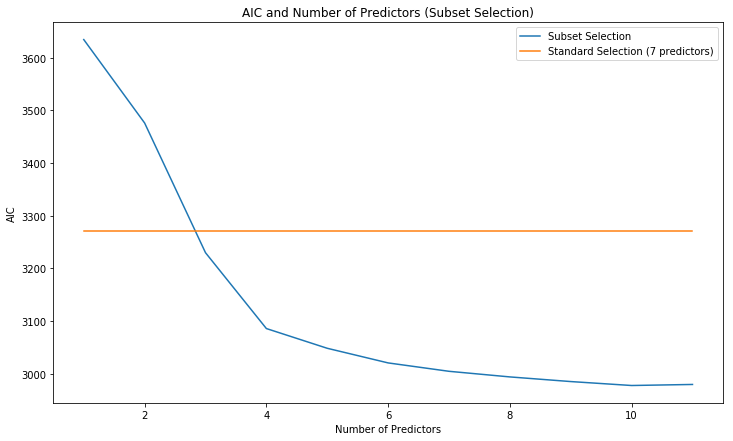

In [66]:
# Change size of figures
fig_size = [12,7]
rcParams["figure.figsize"] = fig_size

# Plot AIC with respect to number of predictors
subset, = plot(range(1,NumbPred+1), AIC_j)

# Plot AIC for model selected using standard method
standard, = plot(range(1,NumbPred+1), [AIC_standard]*NumbPred)

# Label plot
legend([subset, standard], ['Subset Selection', 'Standard Selection (7 predictors)'])
title("AIC and Number of Predictors (Subset Selection)")
xlabel("Number of Predictors")
ylabel("AIC")
show()

The above plot shows that the subset selection model is able to find models with lower AIC than the standard selection method. There are linear models with less than 7 predictors (chosen using the standard approach) and have lower AIC. Note the minimum of $AIC_{k}$ for the subset selection method occurs at $k = 10$ predictors. We could select the linear model with 10 predictors above, but notice that there are less complex models with $k < 10$ and $AIC_{k} \approx AIC_{10}.$ I would personally chose the model with 6 predictors as it is not too complex and fits the data well. There seems to be little gain in the model fit from including more than 6 predictors. 

# Stepwise regression

Stepwise regression is a statistical procedure in which the predictors for a linear model are choosen itteratively. There are two popular stepwise regression methods: 1) Forward Selection, 2) Backward Selection. In forward selection we start with the intercept model and add a predictor at each itteration step into the model. Whereas backward selection starts with the complete model (includes all predictors in the data) and removes a predictor at each step. For this notebook we will just discuss forward selection since backward selection is very similar. 


## Forward Selection

Forward selection is the idea of starting with the most basic linear model, that is the intercept model and adding variables into the regression each itteration that optimize a given criteria. Intuitively we will keep improving the model fit by increasing its complexity until the additional variables stop adding predictive value. 

Let us write out an procedure for forward selection. Suppose we have $k$ possible regressors to include:

1. Start with intercept model: $\hat{Y} = \hat{\beta_{0}}$
2. Itterate $k$ (number of regressors) times
3. For each itteration $j$ (j = 1, $\ldots,$ k) add $X_{j}$ into the model: $\hat{Y} = \hat{\beta_{0}} + \hat{\beta_{1}}X_{j}$
4. Compute the criteria function $AIC_{j} = nlog(SSR) + 2m,$ where m = 1 (model complexity) 
5. Pick $X_{j}$ such that the corresponding $AIC_{j}$ is minimized (less than other models for the given itteration)
6. Repeat steps 2) - 5) now starting with the model $\hat{Y} = \hat{\beta_{0}} + \hat{\beta_{1}}X_{j}$ and search over two predictor models (itterate k-1 times and m = 2 now)
7. We will eventually return to the model with all variables: $\hat{Y} = \hat{\beta}_{0} + \hat{\beta}_{1}X_{1} + \ldots + \hat{\beta}_{k}X_{k}$
8. Plot the $AIC_m$ objective function with respect to the number of predictors, and pick model which minimizes $AIC_m.$ 

It is noteworthy to mention that once a predictor is selected to be included in the model during the forward selection itterations it cannot be removed in a subsequent itteration. The forward selection searches over much less than $2^k$ linear models and hence is less computationally intensive than subset selection. 

In [67]:
## Subset selection setup

# Define outcome vector
math = np.array(school_data['Average Math Proficiency'])

# Vector of ones (for B0)
ones = np.ones(len(math))

# List of predictors
#PredList = ['Economic Need Index','School Income Estimate','Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %','Supportive Environment %','Effective School Leadership %','Trust %','Grade High','Community School?']
PredList = ['Economic Need Index','School Income Estimate','Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent', 'Rigorous Instruction %','Community School?']
NumbPred = len(PredList)

# Store if SSR less than this value
AICthres =  float("inf")

# Keep track of list of predictors included in model
PredListIncluded = []
AIC_j_fwd = []

In [68]:
## Implements forward selection algorithm

# Itterate k times (intercept to complete model)
for itter in range(0,NumbPred):

    # Itterate through each variable
    for predictor in PredList:
        
        # Add predictor to model covariate list
        PredListIncluded.append(predictor)
        
        # Model complexity
        NumbPredIncluded = len(PredListIncluded)

        # Define predictor data vector
        xvars = np.array(school_data[PredListIncluded])

        # Define design matrix
        design_matrix = np.column_stack((ones,xvars))

        # Run regression
        AIC = estimate_model_SSR(math,design_matrix,NumbPredIncluded)

        # Store variable that minimizes SSR
        if AIC < AICthres:

            # Update threshold to beat (need lower AIC)
            AICthres = AIC

            # Predictor minimizes SSR
            IncludePred = predictor
            
        # Remove predictor of interest from covariate list (move onto next)
        PredListIncluded.remove(predictor)
    
    # Store AIC for each model (AIC_j, j = # predictors)
    AIC_j_fwd.append(AICthres)

    # Current list of predictors included in model
    PredListIncluded.append(IncludePred)

    # Update list of predictors (remove choosen one) 
    PredList.remove(IncludePred)
    
    # Resert AIC threshold
    AICthres = float("inf")

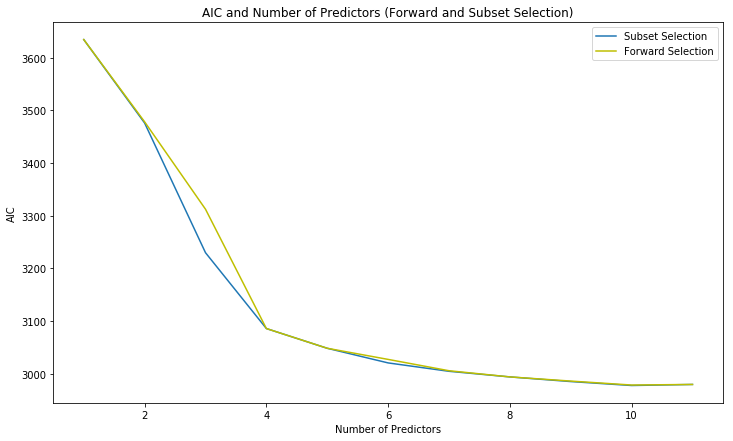

In [69]:
# Plot AIC with respect to number of predictors (subset selection)
subset, = plot(range(1,NumbPred+1), AIC_j)

# Plot AIC with respect to number of predictors (forward selection)
forward, = plot(range(1,NumbPred+1), AIC_j_fwd, 'y')

# Label plot
title("AIC and Number of Predictors (Forward and Subset Selection)")
xlabel("Number of Predictors")
ylabel("AIC")
legend([subset, forward], ['Subset Selection', 'Forward Selection'])
show()

## Selecting a Model From Forward Selection Results

Since subset selection searches over all possible regression models for a given number predictors it always performs atleast as well as forward selection. That is the models searched under forward selection is just a subcollection of the models that subset selection searches over. This is why in the above figure the $AIC_{m}^{subset} \le AIC_{m}^{forward}$ for all $m = 1, \ldots, 11.$ Suppose we decided that the first six predictors should be included in the model, then our linear model would contain the following covariates:

In [51]:
# First set of predictors choosen from forward selection
PredListIncluded[0:6]

['Economic Need Index',
 'Percent Asian',
 'Student Attendance Rate',
 'Percent of Students Chronically Absent',
 'Rigorous Instruction %',
 'Percent White']

# Shrinkage Methods

Shrinkage methods adjust the standard L2 loss function so that the parameters estimates are shrinked towards 0. These methods don't always directly inform us on what predictors should go into the regression model, but they can be suggestive as irrelevant predictors will have small coefficient estimates. 

The two most popular shrinkage methods are 1) Lasso and 2) Ridge regression, the loss functions for both of these regressions are:

$$Error_{Lasso}(\beta) = \frac{1}{2}\sum_{i=1}^{n}(f(x_{i};\beta)-y_{i})^2 + \frac{\lambda}{2} \sum_{i=1}^{k}|\beta_{k}|,$$ and the $L2$ regualirized error function is $$Error_{Ridge}(\beta) = \frac{1}{2}\sum_{i=1}^{n}(f(x_{i};\beta)-y_{i})^2 + \frac{\lambda}{2} \sum_{i=1}^{k}\beta_{k}^{2},$$ where $\lambda$ is the regularization parameter (tuning parameter). Note that using the $L1$ loss function is known as lasso regression, and using the $L2$ loss function is known as ridge regression. The regularized terms $\frac{\lambda}{2} \sum_{i=1}^{k}|\beta_{k}|,\frac{\lambda}{2} \sum_{i=1}^{k}\beta_{k}^{2}$ in the Lasso and Ridge loss functions respectively tend to shrink the parameters $(\beta_{1}, \ldots, \beta_{k})$ towards 0 (notice the intercept $\beta_{0}$ is excluded from the regularized term).


## Ridge vs. Lasso Discussion

Note that ridge and lasso can also be represented as contrained optimization problems:

$$Lasso: \min_{\beta}\frac{1}{2}\sum_{i=1}^{n}(f(x_{i};\beta)-y_{i})^2 \ \text{subject to} \sum_{i=1}^{n}|\beta| < c$$
and 
$$Ridge: \min_{\beta}\frac{1}{2}\sum_{i=1}^{n}(f(x_{i};\beta)-y_{i})^2 \ \text{subject to} \sum_{i=1}^{n} \beta^2 < c^2,$$ where $c$ is a constant that imposes restrictions on the size of the parameter space. If you are fimiliar with lagarangian multipliers from calculus, then the error functions shown in previous section show now make sense. 

Although both ridge and lasso generally shrink coeffecients towards 0, the main difference is that lasso has sparse estimates (many of them are 0) and ridge does not (can be close to 0, but not exactly 0). The figure below illustrates this idea:

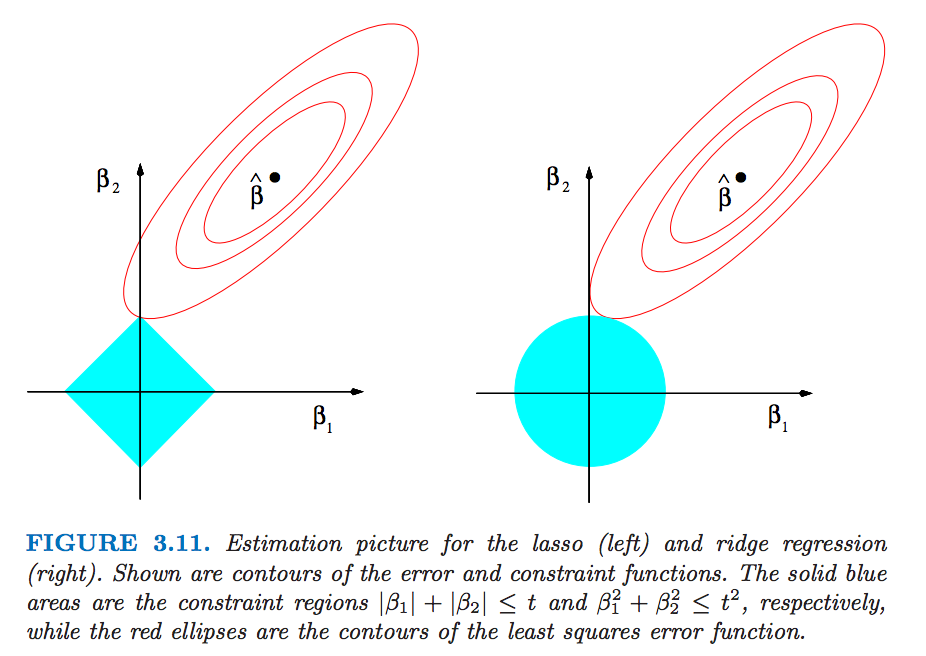

In [25]:
from IPython.display import Image, display
display(Image(filename='LassoVsRidge.png', embed=True))

The blue regions denote the parameter space (imposed by lasso and ridge restrictions) and the black dot is the ordinary least squares (minimizing unrestricted L2 loss) solution. Notice in the left figure for lasso the optimal solution is $\beta_{1} = 0$ and $\beta_{2} \ne 0$ whereas the right figure shows the ridge solution of $\beta_{1}, \beta_{2} \ne 0.$ Hence lasso can actually be used for model selection as the insignificant predictors will be assigned a coeffecient of 0. The parameter restrictions on lasso lead the model estimates to be sparse. 

## Standardizing the data

It is standard practice in ridge regression to standardize the data. This is because the regularization components are impacted by the units of the data. There are many possible standardizations, I will standardize all the variables in the data to have mean 0 and standard deviation 1:
$Standardize(X) = \frac{X - \bar{X}}{SD(X)}.$

In [70]:
# Standardize data
school_data_std = school_data.apply(lambda x: (x - np.mean(x))/(np.std(x)))

# Redefine outcome
math_std = np.array(school_data_std['Average Math Proficiency'])

# Redefine predictor data vector
PredList = ['Economic Need Index','School Income Estimate','Percent ELL','Percent Asian','Percent Black','Percent Hispanic','Percent White','Student Attendance Rate','Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %','Supportive Environment %','Effective School Leadership %','Trust %','Grade High','Community School?']
xvars_full = np.array(school_data_std[PredList])

# Design matrix for full model (standardized)
design_matrix_full = np.column_stack((ones,xvars_full))

## Estimating Ridge Regression

For the standard square loss function, the closed form solution for the parameters is $\hat{\beta} = (X'X)^{-1}X'y,$ and for the $L2$ regularized loss function the closed form solution is $\hat{\beta}_{ridge} = (X'X + \lambda I)^{-1}X'y,$ where I = 
$
\begin{bmatrix}
    0 & 0 & \ldots & 0\\
    0 & 1 & \ldots & 0\\
    0 & 0 & 1 & 0 \\
    \vdots & \vdots & \ldots & \vdots \\
    0 & 0 & \ldots & 1
\end{bmatrix}. 
$

Let us study the relationship between the coeffcient size and the value of $\lambda$ (regularization/tuning parameter).

In [71]:
# Implement closed form solutions for linear and L2 norm regression
def estimate_model(y,X,Lambda):
    
    # X transpose
    Xtranspose = np.matrix.transpose(X)
    
    # Identity matrix (number of parameters is the dimension)
    Identity = np.identity(len(X[1,:]))
    
    # We don't add penalty to intercept
    Identity[0,0] = 0
    
    # Closed form solution is BetaHat = inv(X'X + Lambda*I)*X'y
    # Estimate model parameters (if Lambda = 0, we get standard square loss function result)
    BetaHat = np.dot(np.linalg.inv(np.add(np.dot(Xtranspose,X),Lambda*Identity)),np.dot(Xtranspose,y))
    
    return BetaHat

In [72]:
# List of lambda values
LambdaList = range(0,25000)

# List of coefficients for each predictor
CoeffEstimate = [[] for i in range(NumbPred)]

# Itterate over each lambda
for Lambda in LambdaList:
    
    # Estimate model 
    beta_ridge = estimate_model(math_std, design_matrix_full, Lambda)
    
    # Fill coeffecient list [(lambda_index, coeff)]
    for index in range(NumbPred):
    
        # Append to estimate list
        CoeffEstimate[index].append(beta_ridge[index+1])

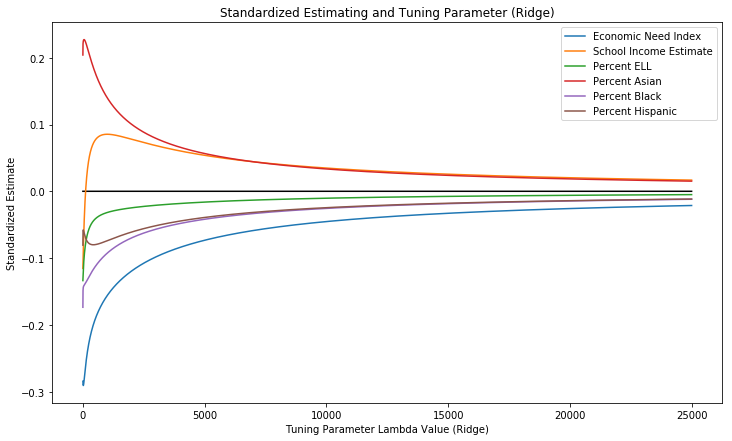

In [73]:
# Plot x-axis (0 line)
plot(LambdaList, np.zeros(len(LambdaList)), color='black')

# Plot coeffecients of above predictors with respect to tuning param
for index in range(0,6):
    plot(LambdaList, CoeffEstimate[index], label = PredList[index])
    
# Label plot
title("Standardized Estimating and Tuning Parameter (Ridge)")
xlabel("Tuning Parameter Lambda Value (Ridge)")
ylabel("Standardized Estimate")
legend()
show()

Not surprisingly, as $\lambda$ grows large the parameter estimates tend towards 0. Although ridge regression cannot be directly used for model selection, it can still inform us about the relevant determinants of the outcome. 

## Estimating Lasso Regression

In constrast to ridge regression, since the lasso loss function is not differentiable everywhere (because of the $|\beta|$ terms) there is no closed form solution to the lasso regression parameters. However it is possible to leverage convex optimation techniques to estimate the lasso model. Since I am currently not fimiliar with convex optimization, I use scikit-learn library in python for implementation. 

In [74]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, outcome, alpha):
    
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=False, max_iter=1e5)
    lassoreg.fit(data[predictors],outcome)
    y_pred = lassoreg.predict(data[predictors])
    
    # Store coeffecients
    result = lassoreg.coef_
    
    return result

In [75]:
## Code below computes lasso estimates for given lambda
# List of lambda values
LambdaList = np.arange(0.0005, 0.25, 0.0001)

# List of coefficients for each predictor
CoeffEstimate = [[] for i in range(NumbPred)]

# Itterate over each lambda
for Lambda in LambdaList:

    # Run lasso regression with given lambda
    coef_matrix_lasso = lasso_regression(school_data_std, PredList, math_std, Lambda)
    
    # Fill coeffecient list [(lambda_index, coeff)]
    for index in range(NumbPred):
    
        # Append to estimate list
        CoeffEstimate[index].append(coef_matrix_lasso[index+1])

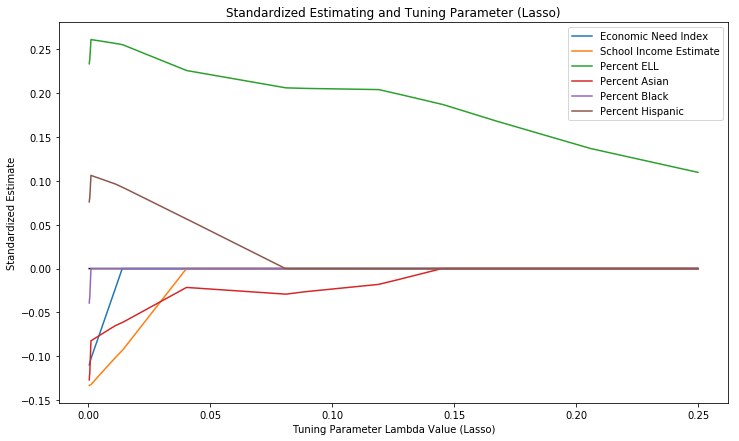

In [76]:
# Plot x-axis (0 line)
plot(LambdaList, np.zeros(len(LambdaList)), color='black')

# Plot coeffecients of above predictors with respect to tuning param
for index in range(0,6):
    plot(LambdaList, CoeffEstimate[index], label = PredList[index])
    
# Label plot
title("Standardized Estimating and Tuning Parameter (Lasso)")
xlabel("Tuning Parameter Lambda Value (Lasso)")
ylabel("Standardized Estimate")

legend()
show()

Although this notebook does not discuss the procedure for selecting the tuning parameter (cross validation), suppose we were given the optimal $\lambda^*.$ Then it is clear from the above figure that lasso can be used for model selection, as for the given $\lambda^*$ we will likely have some predictors that are assigned a coeffecient of 0. Hence lasso is directly informative of what predictors should be included in the linear model.

# Conclusion

This notebook discusses three popular methods for linear model selection: 1) subset selection, 2) stepwise regression, and 3) shrinkage methods. We showed that subset selection performs at least as well as stepwise regression but is very computationally intensive and is infeasible for large number of predictors. We achieved similar conclusions with the subset selection and stepwise regression. Although ridge regression cannot be directly used for model selection, lasso can as it generally results in sparse estimates where many of the predictors are assigned a coeffecient of 0. 